# Real Time Number Plate Processing
### For Object Detection - Used Tiny yolov3 to as a pre trained model to train weights, labelled custom training data used labelimg- https://github.com/tzutalin/labelImg, used darkflow network in particular for custom object detection. 
### For Text Processing and Recognition - Used pytessaract for OCR. 
#### Still lot of training required for robust use. This is just a prototype.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/darkflow-master')

In [4]:
!python3 setup.py build_ext --inplace

setup.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
running build_ext
copying build/lib.linux-x86_64-3.7/darkflow/cython_utils/nms.cpython-37m-x86_64-linux-gnu.so -> darkflow/cython_utils
copying build/lib.linux-x86_64-3.7/darkflow/cython_utils/cy_yolo2_findboxes.cpython-37m-x86_64-linux-gnu.so -> darkflow/cython_utils
copying build/lib.linux-x86_64-3.7/darkflow/cython_utils/cy_yolo_findboxes.cpython-37m-x86_64-linux-gnu.so -> darkflow/cython_utils


In [5]:
import cv2
from darkflow.net.build import TFNet
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.











In [6]:
import tensorflow as tf
#using tensorflow 1.x.x since there need to changes done to library for it to work with tensorflow 2.x
tf.__version__  


'1.15.2'

# Training The Weights 

In [7]:
%%time
options = {"model": "cfg/yolo-voc-1c.cfg", 
           "load": "weights/tiny-yolo-voc.weights",
           "batch": 4,
           "gpu": 1.0,
           "epoch": 300,
           "train": True,
           "annotation": "new_data/labels",
           "dataset": "new_data/images"}

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [8]:
%%time
from darkflow.net.build import TFNet
tfnet = TFNet(options)

Parsing ./cfg/tiny-yolo-voc.cfg
Parsing cfg/yolo-voc-1c.cfg
Loading weights/tiny-yolo-voc.weights ...
Successfully identified 63471556 bytes
Finished in 0.44736456871032715s

Building net ...

Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------



       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 32)

 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 128)
 Load  |  Yep!  | conv 3x3p1_1 

In [9]:
%%time
tfnet.train()


cfg/yolo-voc-1c.cfg parsing new_data/labels
Parsing for ['plate'] 
[==>                 ]11%  IMG_20200514_094037_004.xml

KeyboardInterrupt: ignored

# Using Previously Trained Weights

In [13]:
%%time
options = {
 'model': 'cfg/yolo-voc-1c.cfg',
 'load': 24000,
 'gpu':1.0,
 'train':True,
 'threshold': 0.1,
 'backup':'ckpt/',
 "annotation": "new_data/labels",
 "dataset": "new_data/images",
 "batch":4,
 "epoch":100
 
}
tfnet2 = TFNet(options)

Parsing cfg/yolo-voc-1c.cfg
Loading None ...
Finished in 0.000110626220703125s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 104, 104, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 256)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 52, 

In [14]:
tfnet2.load_from_ckpt()

Loading from ckpt/yolo-voc-1c-24000
INFO:tensorflow:Restoring parameters from ckpt/yolo-voc-1c-24000


In [ ]:
#tfnet2.train()

In [15]:
# read the color image and covert to RGB
import cv2

img = cv2.imread('new_data/images/licensed_car168.jpeg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# use YOLO to predict the image
result = tfnet2.return_predict(img)

img.shape

(336, 642, 3)

In [16]:
result

[{'bottomright': {'x': 445, 'y': 198},
  'confidence': 0.9204903,
  'label': 'plate',
  'topleft': {'x': 208, 'y': 144}}]

In [17]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,863 kB/s)
debconf: unable to initi

In [18]:
import cv2
import pytesseract
import numpy as np

In [19]:
from google.colab.patches import cv2_imshow

def my_function(image):
    
    # USAGE
    # python correct_skew.py --image images/neg_28.png
    
    # import the necessary packages
    import numpy as np
    #import argparse
    import cv2
    
    # construct the argument parse and parse the arguments
    """ap = argparse.ArgumentParser()
    ap.add_argument("-i", "--image", required=True,
        help="path to input image file")
    args = vars(ap.parse_args())"""
    
    # load the image from disk
    #image = cv2.imread(img)
    
    # convert the image to grayscale and flip the foreground
    # and background to ensure foreground is now "white" and
    # the background is "black"
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    
    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)
    
    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle
    
    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    # draw the correction angle on the image so we can validate it
    #cv2.putText(rotated, "Angle: {:.2f} degrees".format(angle),
    #    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # show the output image
    print("[INFO] angle: {:.3f}".format(angle))
    cv2_imshow( image)
    cv2_imshow( rotated)
    return rotated
    cv2.waitKey(0)

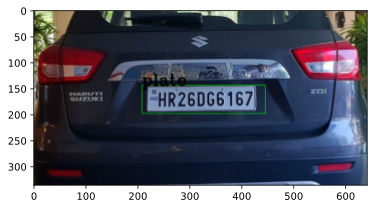

[INFO] angle: -0.000


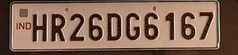

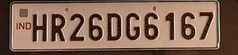

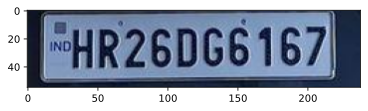

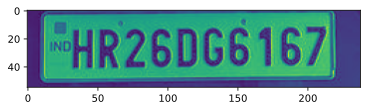

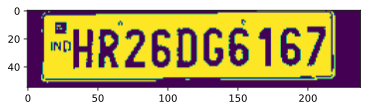

OUTPUT: HR26DG6 167,

Number of Characters: 14


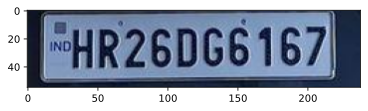

In [20]:

img1=img.copy()
# pull out some info from the results
for i in range(0, len(result)):
    tl = (result[i]['topleft']['x'], result[i]['topleft']['y'])
    br = (result[i]['bottomright']['x'], result[i]['bottomright']['y'])
    label = result[i]['label']
# add the box and label and display it
    img = cv2.rectangle(img, tl, br, (0, 255, 0), 1)
    img = cv2.putText(img, label, tl, cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
    plt.imshow(img)
    #image[1:(y2 + 1), 1:(x2 + 1)]
plt.show()

for i in range(0,len(result)):
    tl = (result[i]['topleft']['x'], result[i]['topleft']['y'])
    br = (result[i]['bottomright']['x'], result[i]['bottomright']['y'])
    label = result[i]['label']
    cropped=img1[tl[1]:(br[1] + 1), tl[0]:(br[0] + 1)]
    cropped=my_function(cropped)
    image = cropped
    plt.imshow(image)
    plt.show()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    plt.show()
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    plt.imshow(gray)
    plt.show()
    plt.show()
    out_below = pytesseract.image_to_string(gray)
    print("OUTPUT:", out_below)
    print("Number of Characters:", len(out_below))
    plt.imshow(cropped)
    plt.show()

# Real Time Number Plate Recognition
### Requires a little more work and optimisation

In [ ]:
import numpy as np
import time

In [ ]:
capture = cv2.VideoCapture('1.mp4')
colors = [tuple(255 * np.random.rand(3)) for i in range(10)]

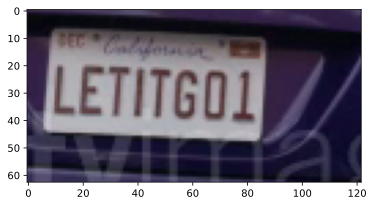

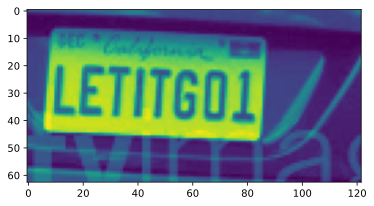

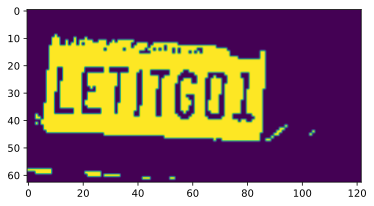

OUTPUT:  1


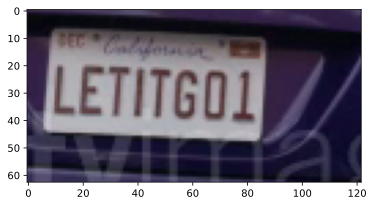

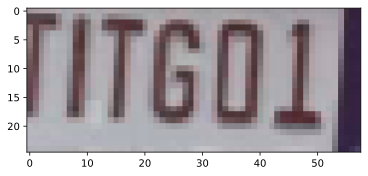

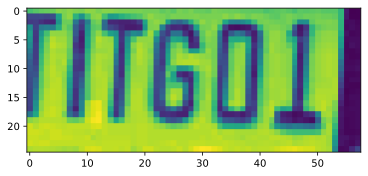

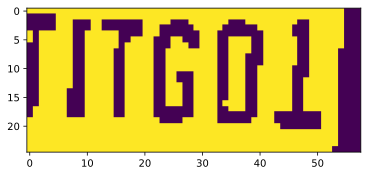

OUTPUT: TOL
 5


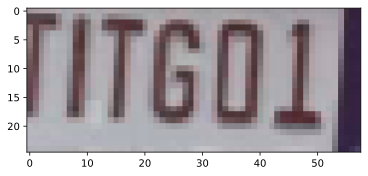

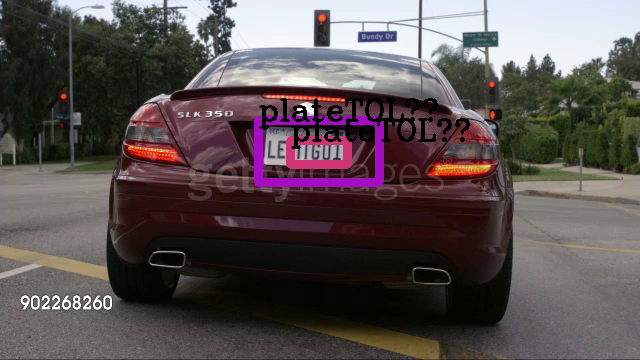

FPS 0.4


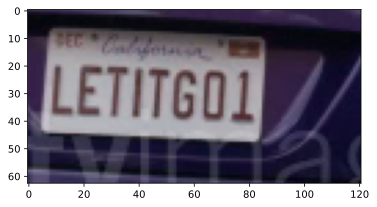

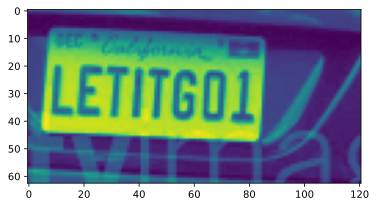

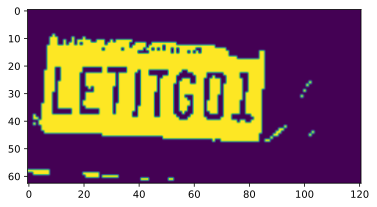

OUTPUT:  1


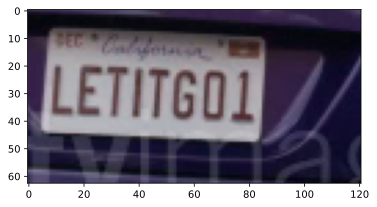

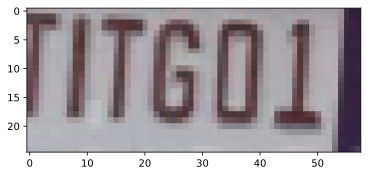

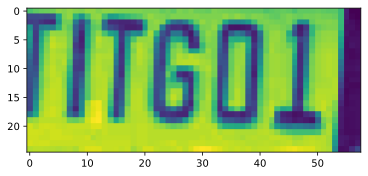

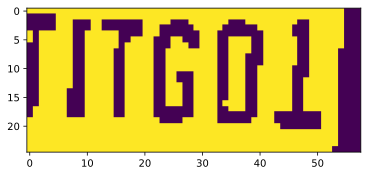

OUTPUT: TOL
 5


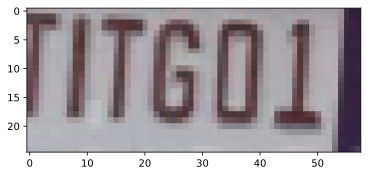

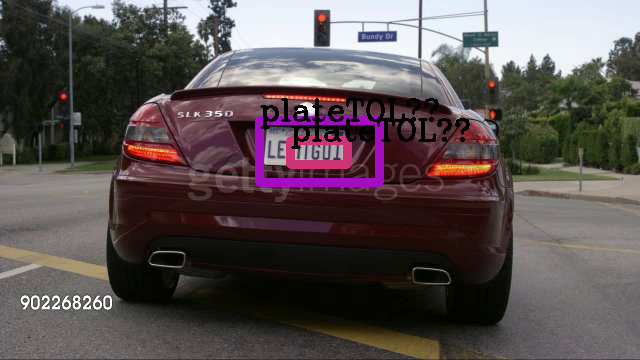

FPS 0.4


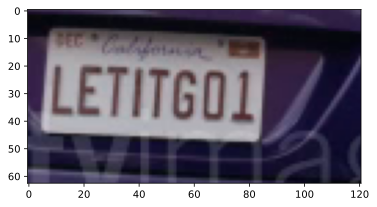

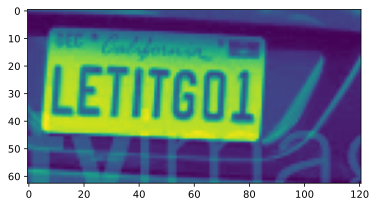

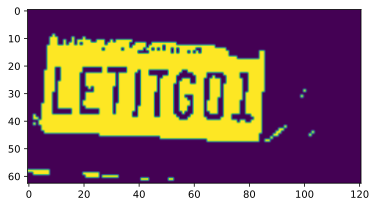

OUTPUT:  1


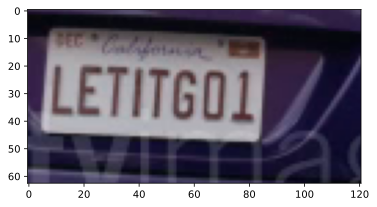

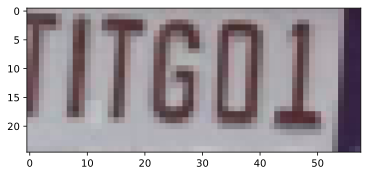

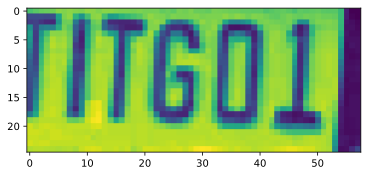

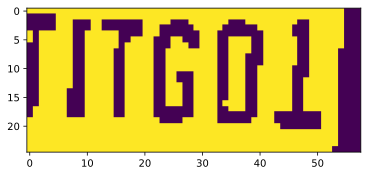

OUTPUT: TOL
 5


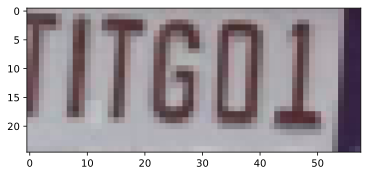

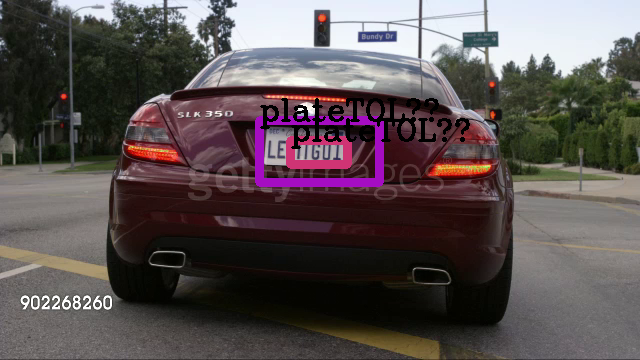

FPS 0.4


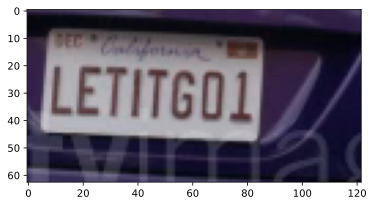

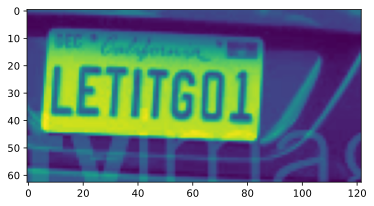

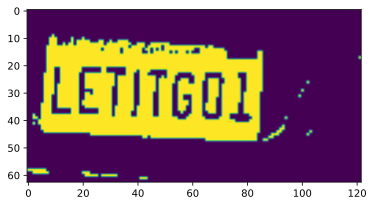

OUTPUT:  1


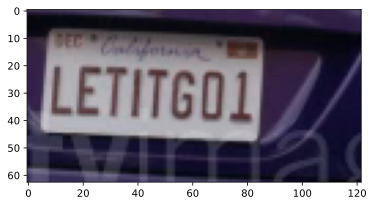

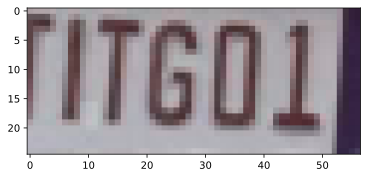

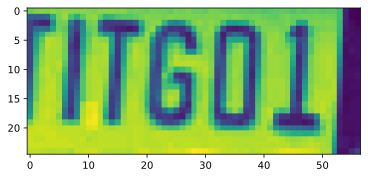

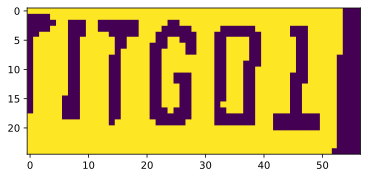

OUTPUT: TGGL
 6


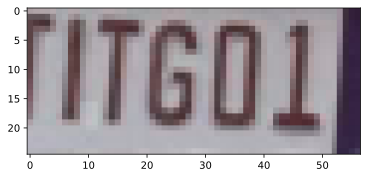

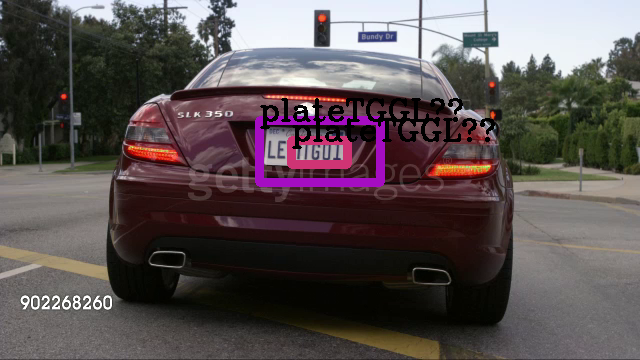

FPS 0.4


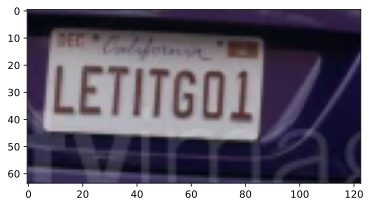

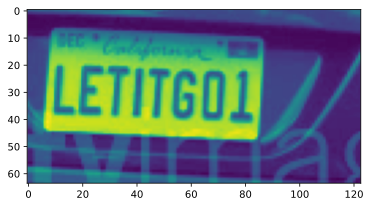

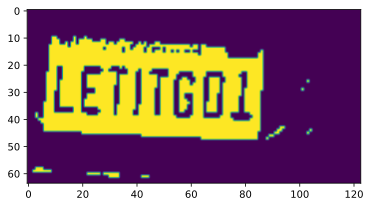

OUTPUT:  1


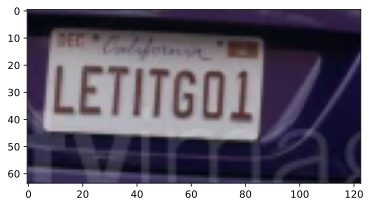

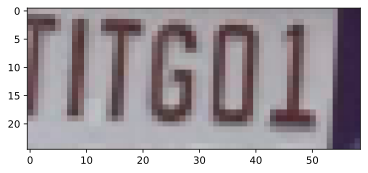

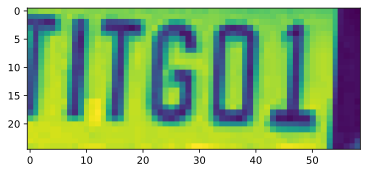

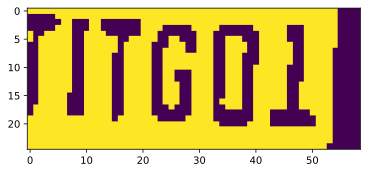

OUTPUT: ITGOL
 7


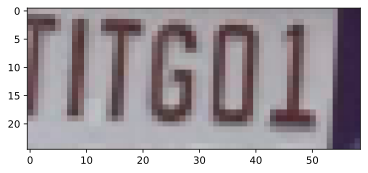

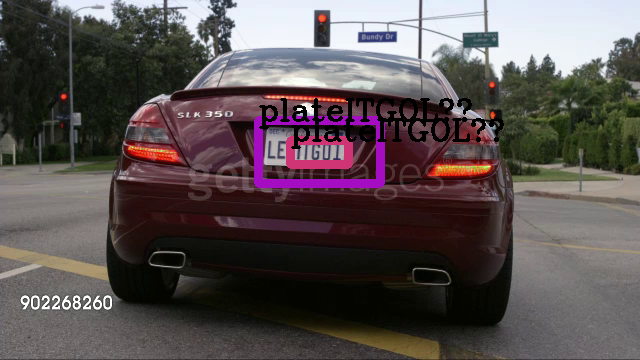

FPS 0.4


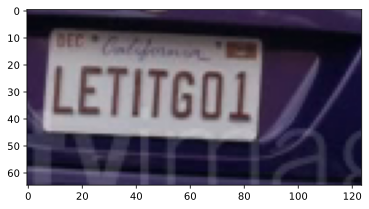

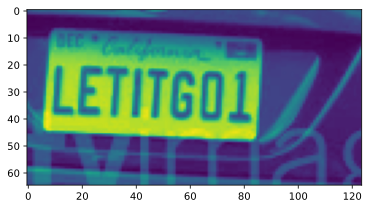

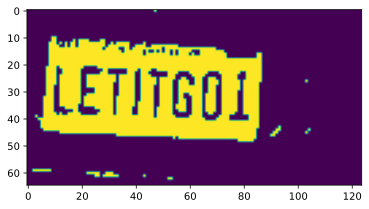

OUTPUT:  1


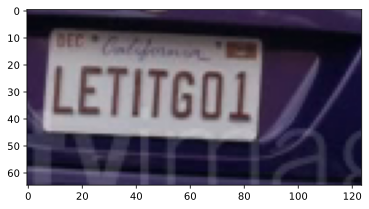

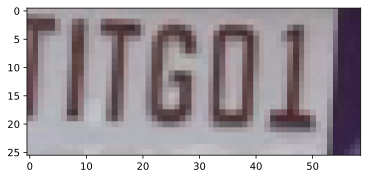

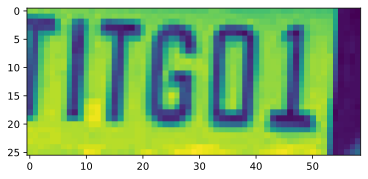

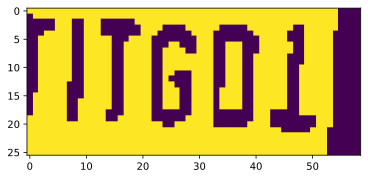

OUTPUT: TEL
 5


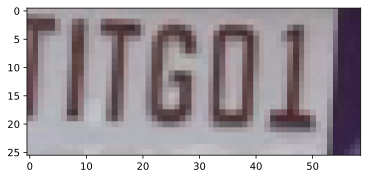

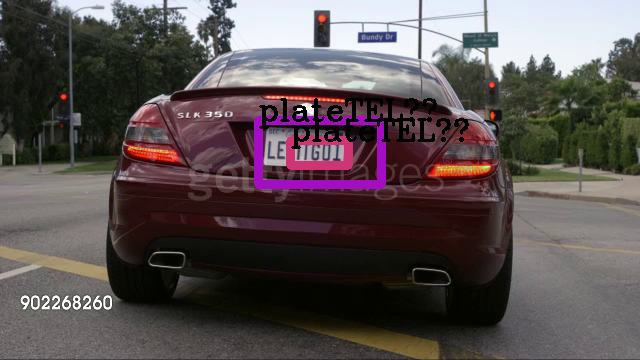

FPS 0.4


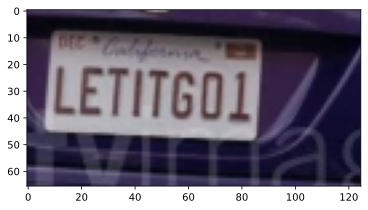

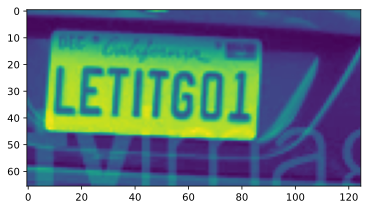

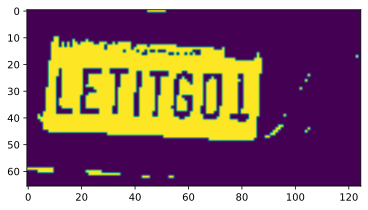

OUTPUT:  1


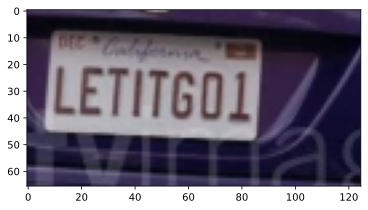

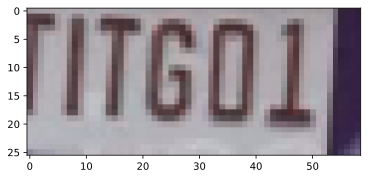

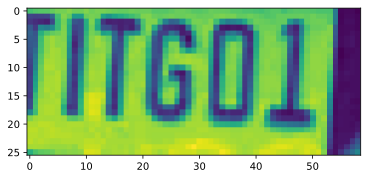

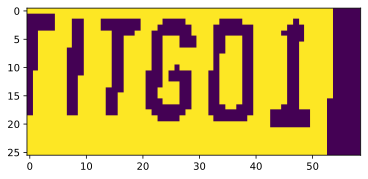

OUTPUT: TGOL
 6


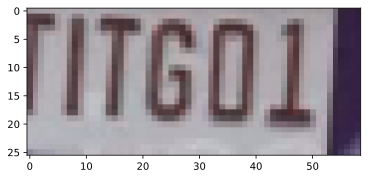

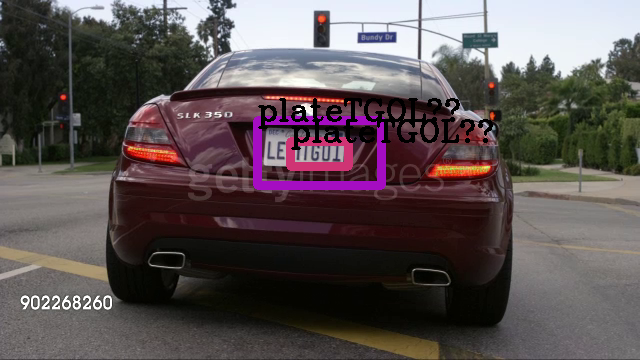

FPS 0.4


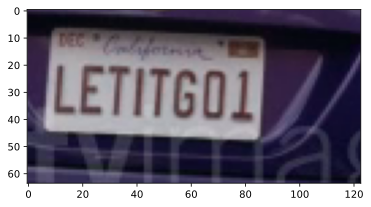

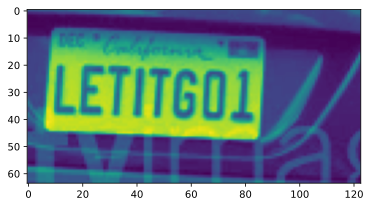

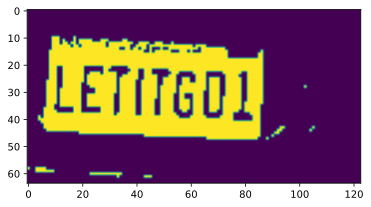

OUTPUT:  1


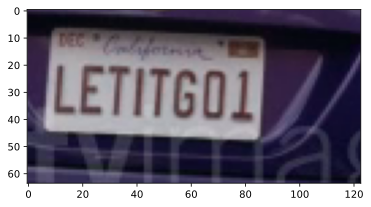

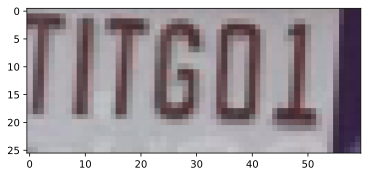

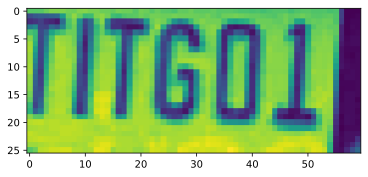

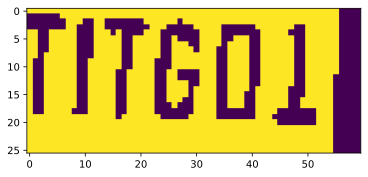

OUTPUT: Té01
 6


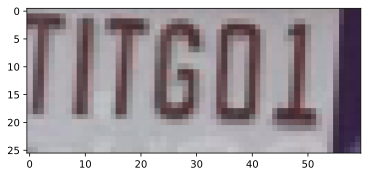

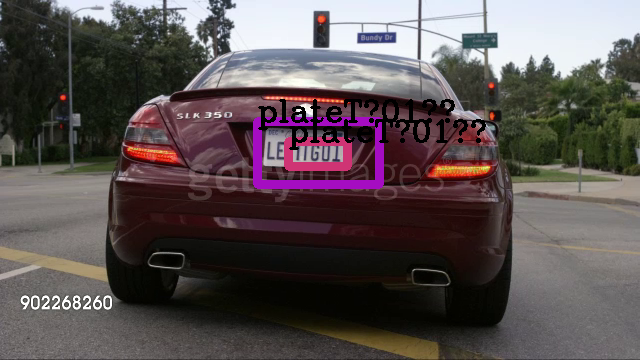

FPS 0.4


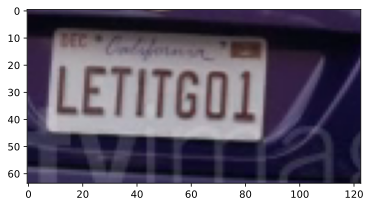

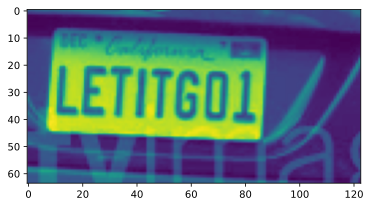

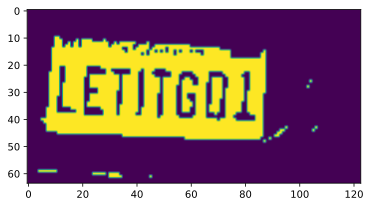

OUTPUT:  1


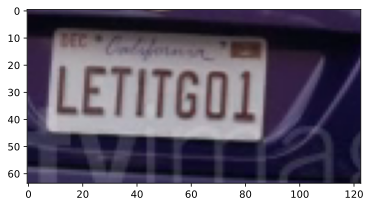

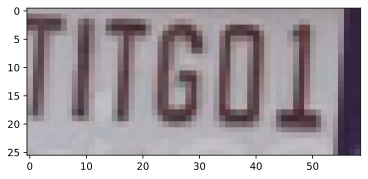

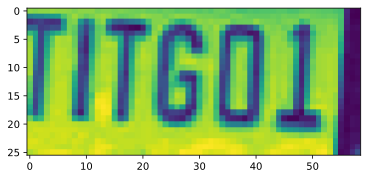

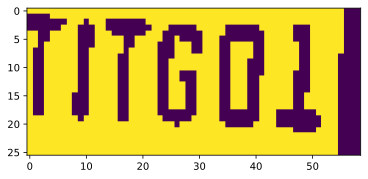

OUTPUT: TéOL|
 7


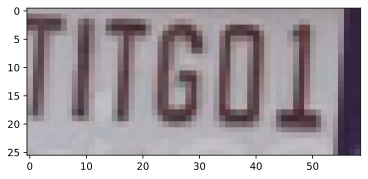

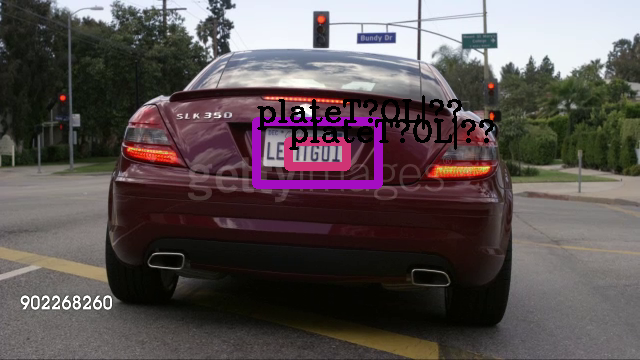

FPS 0.4


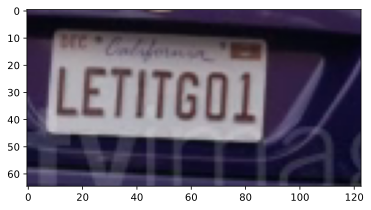

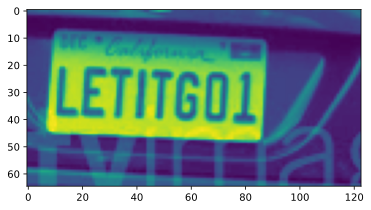

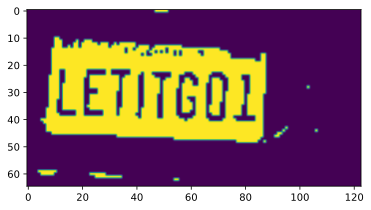

OUTPUT:  1


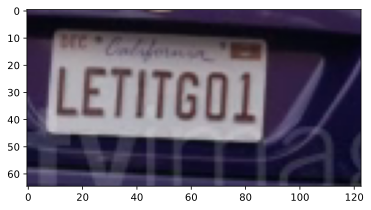

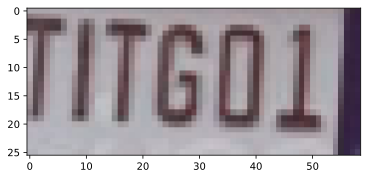

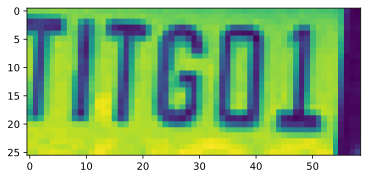

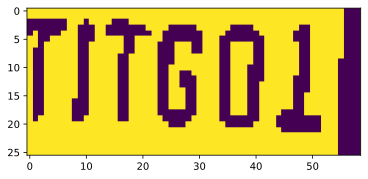

OUTPUT: TOL)
 6


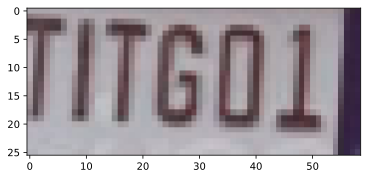

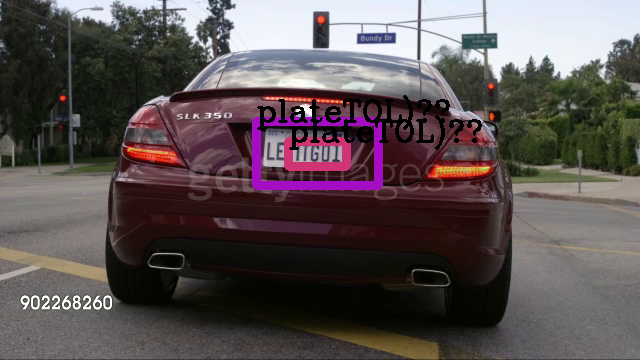

FPS 0.4


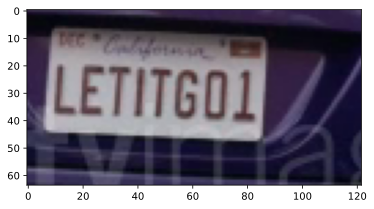

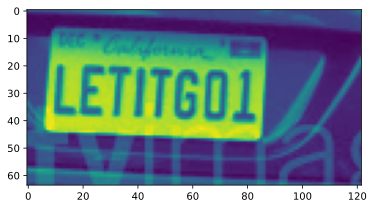

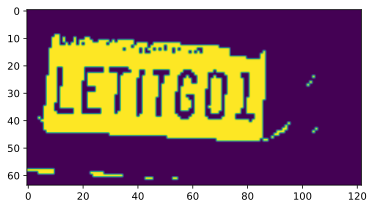

OUTPUT:  1


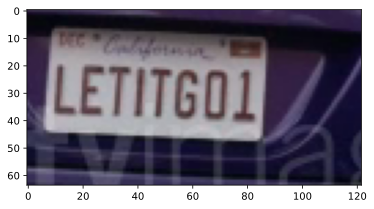

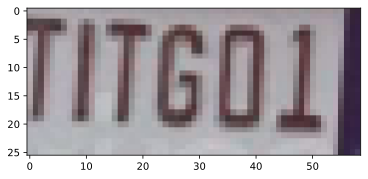

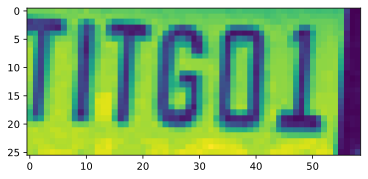

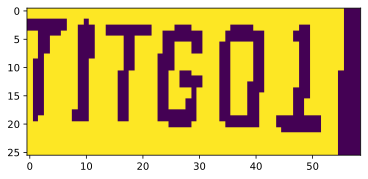

OUTPUT: TITéQL|
 9


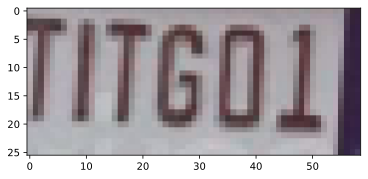

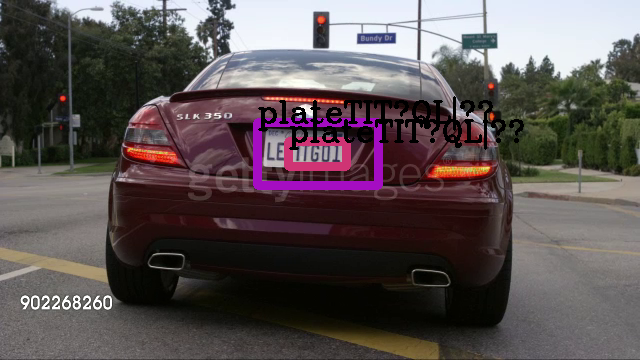

FPS 0.3


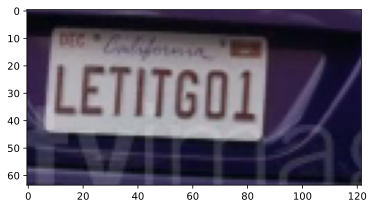

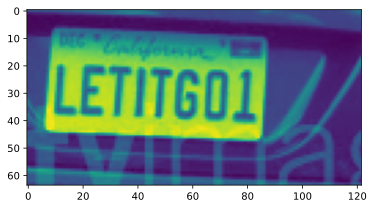

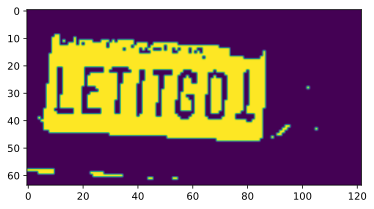

OUTPUT:  1


In [ ]:
while (capture.isOpened()):
    stime = time.time()
    ret, frame = capture.read()# ret is a boolean. True when the video is playing.
    frame1=frame.copy()
    if ret:
        results = tfnet2.return_predict(frame)
        
        for color, result in zip(colors, results):
            tl = (result['topleft']['x'], result['topleft']['y'])
            br = (result['bottomright']['x'], result['bottomright']['y'])
            label = result['label']
            cropped=frame1[tl[1]:(br[1] + 1), tl[0]:(br[0] + 1)]
            image = cropped
            plt.imshow(image)
            plt.show()
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            plt.imshow(gray)
            plt.show()
            gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
            plt.imshow(gray)
            plt.show()
            plt.show()
            out_below = pytesseract.image_to_string(gray)
            print("OUTPUT:", out_below,len(out_below))
            plt.imshow(cropped)
            plt.show()
        for color, result in zip(colors, results):
            tl = (result['topleft']['x'], result['topleft']['y'])
            br = (result['bottomright']['x'], result['bottomright']['y'])
            label = result['label']
            frame = cv2.rectangle(frame, tl, br, color, 7)
            frame = cv2.putText(frame, label+out_below, tl, cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
        cv2_imshow(frame)
        #cv2.imshow('frame', frame)
        print('FPS {:.1f}'.format(1 / (time.time() - stime)))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        capture.release()
        cv2.destroyAllWindows()
        break

In [ ]:
capture.release()
cv2.destroyAllWindows()

#### Image Recognition working without detection

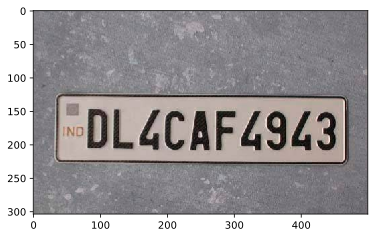

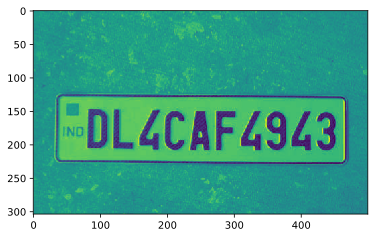

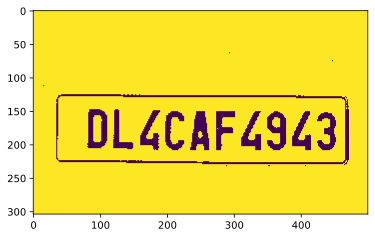

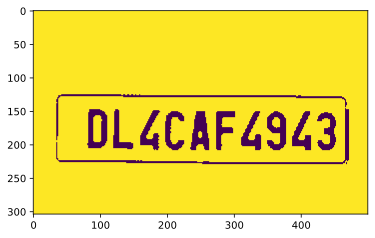

OUTPUT: DL4CAF 4943


In [ ]:
image = cv2.imread("23.jpeg")
plt.imshow(image)
plt.show()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray = cv2.bitwise_not(gray)
plt.imshow(gray)
plt.show()
gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(gray)
plt.show()
gray = cv2.medianBlur(gray, 3)
plt.imshow(gray)
plt.show()
out_below = pytesseract.image_to_string(gray)
print("OUTPUT:", out_below)